This task was a sentiment classification task based on the IMDB movie reviews. I performed the task to better understand how word embeddings can be used to represent words in a lower-dimensional space as an alternative to one-hot encoding which results in very sparse, very high-dimensional vector representations of words

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras import models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os

imdb_dir = './aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = list()
texts = list()

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
maxlen = 100 #keep only the last 100 elements of every vector sequence
training_samples = 200 #train on only 200 reviews
validation_samples = 10000 #validate on 10000 reviews
max_words = 1000 #Restrict dictionary to the 1000 most common words across all reviews

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index #dictionary of unique words

In [4]:
print('Found {0} unique words'.format(len(word_index)))

Found 88582 unique words


In [5]:
data = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [6]:
labels = np.asarray(labels)

In [7]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [8]:
indices = np.arange(data.shape[0])
indices

array([    0,     1,     2, ..., 24997, 24998, 24999])

In [9]:
np.random.shuffle(indices)
indices

array([ 7768, 19458, 12516, ...,  5896,  1954, 14531])

In [10]:
data = data[indices]
labels = labels[indices]

In [11]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

In [12]:
y_train

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0])

In [33]:
#Next we import the Stanford GloVe directory

glove_dir = './glove/'
embeddings_index = dict()

f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' %len(embeddings_index))

Found 400000 word vectors


In [34]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [73]:
model = models.Sequential()

model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          300000    
                                                                 
 gru_4 (GRU)                 (None, 100, 32)           32064     
                                                                 
 gru_5 (GRU)                 (None, 100, 32)           6336      
                                                                 
 gru_6 (GRU)                 (None, 32)                6336      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 344,769
Trainable params: 344,769
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.layers

In [75]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [76]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/15
7/7 [==============================] - 8s 835ms/step - loss: 0.7003 - acc: 0.4400 - val_loss: 0.6970 - val_acc: 0.5097
Epoch 2/15
7/7 [==============================] - 4s 737ms/step - loss: 0.6737 - acc: 0.6350 - val_loss: 0.7023 - val_acc: 0.5264
Epoch 3/15
7/7 [==============================] - 5s 742ms/step - loss: 0.6515 - acc: 0.6350 - val_loss: 0.7006 - val_acc: 0.5324
Epoch 4/15
7/7 [==============================] - 5s 744ms/step - loss: 0.6305 - acc: 0.6850 - val_loss: 0.6922 - val_acc: 0.5556
Epoch 5/15
7/7 [==============================] - 5s 751ms/step - loss: 0.6021 - acc: 0.6900 - val_loss: 0.7118 - val_acc: 0.5575
Epoch 6/15
7/7 [==============================] - 5s 746ms/step - loss: 0.5575 - acc: 0.7300 - val_loss: 0.7336 - val_acc: 0.5546
Epoch 7/15
7/7 [==============================] - 5s 782ms/step - loss: 0.4952 - acc: 0.8150 - val_loss: 0.7547 - val_acc: 0.5682
Epoch 8/15
7/7 [==============================] - 5s 842ms/step - loss: 0.4498 - acc: 0.80

In [77]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

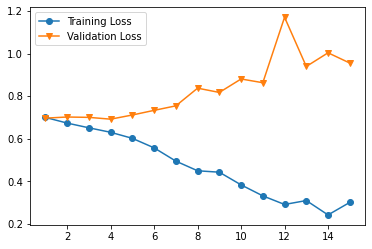

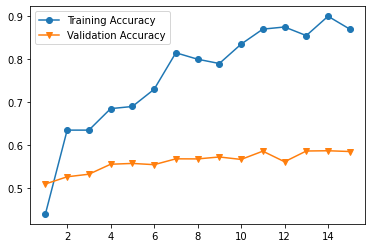

In [78]:
epochs = list(np.linspace(1, len(history_dict['loss']), len(history_dict['loss'])))

training_loss = history_dict['loss']
training_acc = history_dict['acc']
validation_loss = history_dict['val_loss']
validation_acc = history_dict['val_acc']

plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='v', label='Validation Loss')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, training_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, validation_acc, marker='v', label='Validation Accuracy')
plt.legend()
plt.show()

In [79]:
test_dir = os.path.join(imdb_dir, 'test')

labels = list()
texts = list()

for label_type in ['neg','pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [80]:
sequences = tokenizer.texts_to_sequences(texts)

In [81]:
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [82]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 11s 14ms/step - loss: 1.0141 - acc: 0.6008


[1.0141419172286987, 0.6008399724960327]